In [1]:
import pyspark,csv
from pyspark import SparkContext
sc=SparkContext()

In [2]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

### 1. Load CSV into Spark as textfile

In [3]:
rdd=sc.textFile("AppleStore.csv")
rdd

AppleStore.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

### 2. Parse the data as CSV

#### Open file and Read

#### We cannot always split using coma(',')

#### RDD transformations and actions can only be invoked by the driver,not inside of other transformations;

In [4]:
header = rdd.first() # Save the header
rdd = rdd.filter(lambda row: row != header) # Remove the header
# Split each row by comma and convert to a list
rdd = rdd.map(lambda row: csv.reader([row]).__next__())
# We then split each row by comma using the csv.reader method and convert it to a list using the __next__ method
rdd.take(1)

[['1',
  '281656475',
  'PAC-MAN Premium',
  '100788224',
  'USD',
  '3.99',
  '21292',
  '26',
  '4',
  '4.5',
  '6.3.5',
  '4+',
  'Games',
  '38',
  '5',
  '10',
  '1']]

### 3.Convert bytes to MB and GB in a new column

#### Add at end of column

#### Add at respective position of column

In [5]:
rdd2=rdd.map(lambda x: (*x[0:3],float(x[3])/(1024*1024),float(x[3])/(1024*1024*1024),*x[3:]))
rdd2.take(1)

[('1',
  '281656475',
  'PAC-MAN Premium',
  96.119140625,
  0.09386634826660156,
  '100788224',
  'USD',
  '3.99',
  '21292',
  '26',
  '4',
  '4.5',
  '6.3.5',
  '4+',
  'Games',
  '38',
  '5',
  '10',
  '1')]

###  4.List top 10 trending apps

In [6]:
rdd.sortBy(lambda x: float(x[6]),ascending=False).map(lambda x: (x[1], x[2], x[6])).take(10)

[('284882215', 'Facebook', '2974676'),
 ('389801252', 'Instagram', '2161558'),
 ('529479190', 'Clash of Clans', '2130805'),
 ('420009108', 'Temple Run', '1724546'),
 ('284035177', 'Pandora - Music & Radio', '1126879'),
 ('429047995', 'Pinterest', '1061624'),
 ('282935706', 'Bible', '985920'),
 ('553834731', 'Candy Crush Saga', '961794'),
 ('324684580', 'Spotify Music', '878563'),
 ('343200656', 'Angry Birds', '824451')]

### 5.The difference in the average number of screenshots displayed of highest and lowest rating apps.

#### groupByKey

In [7]:
max_rating = rdd.map(lambda x: float(x[8])).max()
min_rating = rdd.map(lambda x: float(x[8])).min()
rdd_filtered = rdd.filter(lambda x: float(x[8])==max_rating or float(x[8])==min_rating)
rdd1=rdd_filtered.map(lambda line: [float(line[8]),int(line[14])]).groupByKey()
rdd1.take(2)
rdd2=rdd1.mapValues(lambda x: sum(x) / len(x))
max_value=rdd2.collect()[1][1]
min_value=rdd2.collect()[0][1]
#print(rdd1.take(2),rdd2.take(2))
#[(0.0, <pyspark.resultiterable.ResultIterable object at 0x7f61a4c93690>), (5.0, <pyspark.resultiterable.ResultIterable object at 0x7f61a574d890>)] [(0.0, 2.582346609257266), (5.0, 3.7134146341463414)]
print(max_value-min_value)

1.1310680248890757


#### reduceByKey

#### reduceByKey requires an argument

#### mapValues vs map

#### reduceByKey,mapValues,sort,first

#### reduceByKey,mapValues,get max and min

#### get max and min , filter ,reduce,mapValues

In [8]:
max_rating = rdd.map(lambda x: float(x[8])).max()
min_rating = rdd.map(lambda x: float(x[8])).min()
rdd_filtered = rdd.filter(lambda x: float(x[8])==max_rating or float(x[8])==min_rating)
rdd1= rdd_filtered.map(lambda x: (float(x[8]), (int(x[14]), 1))).reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1])) 
rdd2= rdd1.mapValues(lambda x: x[0]/x[1])
'''max_value = rdd2.filter(lambda x: x[0]==max_rating).collect()[0][1]
min_value = rdd2.filter(lambda x: x[0]==min_rating).collect()[0][1]'''
max_value=rdd2.collect()[1][1]
min_value=rdd2.collect()[0][1]
print(rdd_filtered.take(2),rdd1.take(2),rdd2.take(2),max_value-min_value)

[['23', '285994151', ':) Sudoku +', '6169600', 'USD', '2.99', '11447', '781', '5', '5', '5.2.6', '4+', 'Games', '40', '5', '1', '1'], ['227', '329174056', 'iLoan Calc (Loan calculator)', '3375104', 'USD', '3.99', '0', '0', '0', '0', '5.1.0', '4+', 'Finance', '37', '5', '3', '1']] [(0.0, (2399, 929)), (5.0, (1827, 492))] [(0.0, 2.582346609257266), (5.0, 3.7134146341463414)] 1.1310680248890757


#### aggregateByKey

In [9]:
max_rating = rdd.map(lambda x: float(x[8])).max()
min_rating = rdd.map(lambda x: float(x[8])).min()
rdd_filtered = rdd.filter(lambda x: float(x[8])==max_rating or float(x[8])==min_rating)
rdd1=rdd_filtered.map(lambda line:(float(line[8]),int(line[14]))).aggregateByKey((0, 0), lambda a, b: (a[0] + b, a[1] + 1), lambda a, b: (a[0] + b[0], a[1] + b[1]))#.mapValues(lambda x: x[0]/x[1])#.sortByKey().first()
rdd2= rdd1.mapValues(lambda x: x[0]/x[1])
max_value=rdd2.collect()[1][1]
min_value=rdd2.collect()[0][1]
#print(rdd_filtered.take(2),rdd1.take(2),rdd2.take(2))
#[['23', '285994151', ':) Sudoku +', '6169600', 'USD', '2.99', '11447', '781', '5', '5', '5.2.6', '4+', 'Games', '40', '5', '1', '1'], ['227', '329174056', 'iLoan Calc (Loan calculator)', '3375104', 'USD', '3.99', '0', '0', '0', '0', '5.1.0', '4+', 'Finance', '37', '5', '3', '1']] [(0.0, (2399, 929)), (5.0, (1827, 492))] [(0.0, 2.582346609257266), (5.0, 3.7134146341463414)]
print(max_value-min_value)

1.1310680248890757


#### foldByKey

In [10]:
max_rating = rdd.map(lambda x: float(x[8])).max()
min_rating = rdd.map(lambda x: float(x[8])).min()
rdd_filtered = rdd.filter(lambda x: float(x[8])==max_rating or float(x[8])==min_rating)
rdd1= rdd_filtered.map(lambda x: (float(x[8]), (int(x[14]), 1))).foldByKey((0, 0), lambda a, b: (a[0]+b[0], a[1]+b[1]))
rdd2= rdd1.mapValues(lambda x: x[0]/x[1])
max_value=rdd2.collect()[1][1]
min_value=rdd2.collect()[0][1]
#print(rdd_filtered.take(2),rdd1.take(2),rdd2.take(2))
#[['23', '285994151', ':) Sudoku +', '6169600', 'USD', '2.99', '11447', '781', '5', '5', '5.2.6', '4+', 'Games', '40', '5', '1', '1'], 
#['227', '329174056', 'iLoan Calc (Loan calculator)', '3375104', 'USD', '3.99', '0', '0', '0', '0', '5.1.0', '4+', 'Finance', '37', '5', '3', '1']] 
#[(0.0, (2399, 929)), (5.0, (1827, 492))] [(0.0, 2.582346609257266), (5.0, 3.7134146341463414)]
print(max_value-min_value)

1.1310680248890757


#### combineByKey

#### We used map in combineBykey

In [11]:
# initialize accumulator as a tuple of (sum, count, min, max)
acc_init = (0, 0, float('inf'), float('-inf'))
max_rating = rdd.map(lambda x: float(x[8])).max()
min_rating = rdd.map(lambda x: float(x[8])).min()
rdd_filtered = rdd.filter(lambda x: float(x[8])==max_rating or float(x[8])==min_rating)

# apply combineByKey with lambda functions for the accumulator initialization and update/merge functions
rdd1 = rdd_filtered.map(lambda line:(float(line[8]),int(line[14]))).combineByKey(lambda value: (value, 1, value, value), 
                        lambda acc, value: (acc[0] + value, acc[1] + 1, min(acc[2], value), max(acc[3], value)), 
                        lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1], min(acc1[2], acc2[2]), max(acc1[3], acc2[3])))

# calculate the average, min and max values
rdd2 = rdd1.mapValues(lambda acc: acc[0] / acc[1])
'''min_value = rdd1.mapValues(lambda acc: acc[2]).min()[1]
max_value = rdd1.mapValues(lambda acc: acc[3]).max()[1]
#print(max_value-min_value) -5'''
max_value=rdd2.collect()[1][1]
min_value=rdd2.collect()[0][1]
#print(rdd1.take(2),rdd2.take(2))
#[(0.0, (2399, 929, 0, 5)), (5.0, (1827, 492, 0, 5))] [(0.0, 2.582346609257266), (5.0, 3.7134146341463414)] 
print(max_value-min_value)

1.1310680248890757


### 6.What percentage of high rated apps support multiplelanguages.

In [12]:
rdd1=rdd.filter(lambda line:float(line[8])==5)
rdd2=rdd1.filter(lambda line:int(line[15])>1)
rdd2.count()/rdd1.count()*100

47.5609756097561

### 7.How does app details contribute to user ratings?

#### Selecting numerical columns

In [13]:
'''def is_numeric(val):
    try:
        float(val)
        return True
    except ValueError:
        return False
# Get the first row of the RDD
first_row = rdd.first()
# Get the indices of the numerical columns
num_cols = []
for i, val in enumerate(first_row):
    if isinstance(val, (int, float)) or (is_numeric(val)):
        num_cols.append(i)
print(num_cols)'''

def is_numeric(value):
    try:
        int(value)
        return True
    except ValueError:
        pass
    
    try:
        float(value)
        return True
    except ValueError:
        pass
    
    return False
num_cols = rdd.first() # Get the first row
#print(num_cols)
num_cols = [i for i, value in enumerate(num_cols) if is_numeric(value)]
#print(num_cols)



In [14]:
rdd2=rdd.map(lambda line:(int(line[14]),(float(line[8]),1))).reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1])).mapValues(lambda x: x[0]/x[1]).sortByKey(ascending=False)
rdd2.take(10)
# More screenshorts more user ratings are there

[(5, 3.814123917388408),
 (4, 3.4408450704225353),
 (3, 3.194055944055944),
 (2, 3.1153846153846154),
 (1, 3.2451612903225806),
 (0, 2.785147801009373)]

* Hence conclusion is that more details like 5 or 4 screenshots may lead to higher ratings and 0 obviously less but 3-2-1 screenshots lead to almost similar results  

#### User Rating vs Numerical Columns

In [15]:
# create a new RDD with (key, value) pairs where the key is the value of the 14th column and the value is a tuple of the numerical column values and a count of 1
rdd2 = rdd.map(lambda line: (int(line[14]), [(float(line[i]), 1) for i in num_cols[2:]]))
# reduce by key and aggregate the numerical column values and counts
rdd3 = rdd2.reduceByKey(lambda a, b: [(a[i][0] + b[i][0], a[i][1] + b[i][1]) for i in range(len(num_cols[2:]))])
# calculate the averages for each numerical column and sort by key (the 14th column value)
rdd4 = rdd3.mapValues(lambda x: [x[i][0] / x[i][1] for i in range(len(num_cols[2:]))]).sortByKey()

'''print(rdd2.take(10))
print("\n")
print(rdd3.take(10))
print("\n")

print(rdd4.take(10))'''
# print the result
rdd4.foreach(print)

In [16]:
column_names=[header.split(',')[i] for i in num_cols[2:]]
column_names

['"size_bytes"',
 '"price"',
 '"rating_count_tot"',
 '"rating_count_ver"',
 '"user_rating"',
 '"user_rating_ver"',
 '"sup_devices.num"',
 '"ipadSc_urls.num"',
 '"lang.num"',
 '"vpp_lic"']

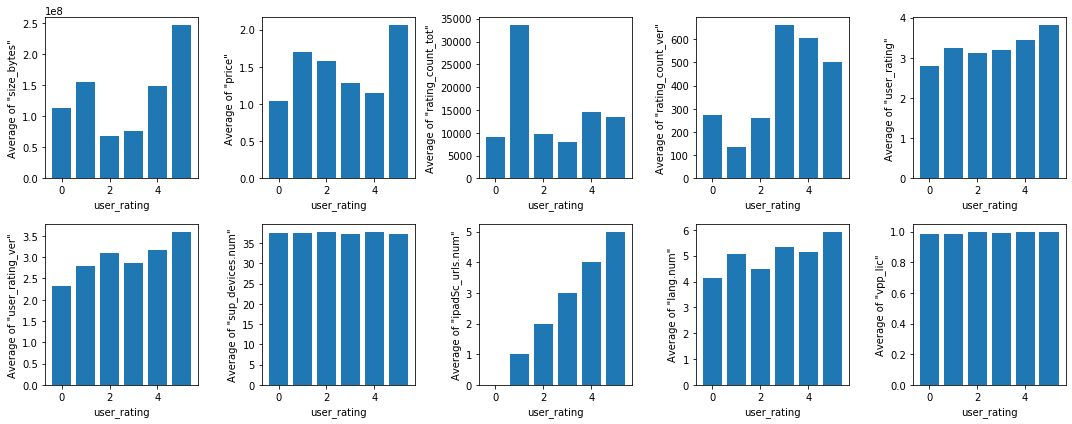

In [17]:

# extract the x-axis and y-axis data from the RDD
data = rdd4.collect()

# create subplots for each numerical column
fig, axs = plt.subplots(2, 5, figsize=(15, 6), tight_layout=True)
axs = axs.flatten()
for i in range(len(num_cols[2:])):
    x = [item[0] for item in data]
    y = [item[1][i] for item in data]
    axs[i].bar(x, y)
    axs[i].set_xlabel("user_rating")
    axs[i].set_ylabel(f"Average of {column_names[i]}")
plt.show()


#### Correlation

In [18]:
# Get the statistics of the numerical columns
num_rdd = rdd.map(lambda x: [float(x[i]) for i in num_cols[2:]])
#print(num_rdd.take(2))

#you need to convert to float because everything is in string

In [19]:
# convert the RDD to an RDD of vectors
rdd_vectors = num_rdd.map(lambda row: Vectors.dense(row))
# calculate the correlation matrix for all pairs of columns
corr_matrix = Statistics.corr(rdd_vectors)

# print the correlation matrix
#print(corr_matrix)


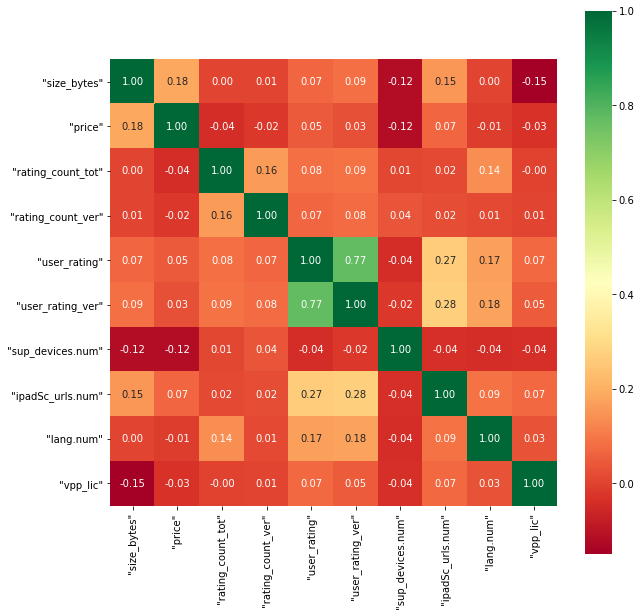

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, cmap='RdYlGn', square=True,annot=True,fmt='.2f',xticklabels=column_names, yticklabels=column_names, )

* ipadSC_urls.num, lang.num is contributing more to user_ratings

### 8.Compare the statistics of different app groups/genres.

### Compare stats of Numerical cols

#### using rdd

In [21]:
col_stats = [num_rdd.map(lambda x: x[i]).stats() for i in range(len(num_rdd.first()))]
col_stats

[(count: 7197, mean: 199134453.82506615, stdev: 359181957.3491751, max: 4025969664.0, min: 589824.0),
 (count: 7197, mean: 1.7262178685563434, stdev: 5.832600534178518, max: 299.99, min: 0.0),
 (count: 7197, mean: 12892.907183548676, stdev: 75734.14661832794, max: 2974676.0, min: 0.0),
 (count: 7197, mean: 460.3739057940814, stdev: 3920.182806581624, max: 177050.0, min: 0.0),
 (count: 7197, mean: 3.5269556759761054, stdev: 1.517842132998665, max: 5.0, min: 0.0),
 (count: 7197, mean: 3.2535778796720827, stdev: 1.8092371161788576, max: 5.0, min: 0.0),
 (count: 7197, mean: 37.36181742392667, stdev: 3.7374555580828765, max: 47.0, min: 9.0),
 (count: 7197, mean: 3.707100180630819, stdev: 1.9858666656879265, max: 5.0, min: 0.0),
 (count: 7197, mean: 5.434903431985542, stdev: 7.919042502800594, max: 75.0, min: 0.0),
 (count: 7197, mean: 0.9930526608309023, stdev: 0.08306066245562785, max: 1.0, min: 0.0)]

#### using mllib Statistics

In [22]:
col_stats = Statistics.colStats(num_rdd)
col_stats.mean(),col_stats.variance(),col_stats.count(),col_stats.max(),col_stats.min()

(array([1.99134454e+08, 1.72621787e+00, 1.28929072e+04, 4.60373906e+02,
        3.52695568e+00, 3.25357788e+00, 3.73618174e+01, 3.70710018e+00,
        5.43490343e+00, 9.93052661e-01]),
 array([1.29029607e+17, 3.40239565e+01, 5.73645803e+09, 1.53699688e+07,
        2.30416490e+00, 3.27379383e+00, 1.39705152e+01, 3.94421445e+00,
        6.27199489e+01, 6.90003238e-03]),
 7197,
 array([4.02596966e+09, 2.99990000e+02, 2.97467600e+06, 1.77050000e+05,
        5.00000000e+00, 5.00000000e+00, 4.70000000e+01, 5.00000000e+00,
        7.50000000e+01, 1.00000000e+00]),
 array([5.89824e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 9.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]))

#### Calculating by code

In [23]:

n_rows=num_rdd.count()
# Calculate means
sums = num_rdd.reduce(lambda x, y: [x[i] + y[i] for i in range(10)])
means = [x / n_rows for x in sums]

# Calculate variances
variances = num_rdd.map(lambda x: [(x[i] - means[i]) ** 2 for i in range(10)]) \
                   .reduce(lambda x, y: [x[i] + y[i] for i in range(10)])
variances = sc.parallelize(variances).map(lambda x: x / (n_rows - 1))

# Calculate minimums
mins = num_rdd.reduce(lambda x, y: [min(x[i], y[i]) for i in range(10)])

# Calculate maximums
maxs = num_rdd.reduce(lambda x, y: [max(x[i], y[i]) for i in range(10)])
# Print the results
print("Means:", means)
print("Variances:", variances.collect())
print("Minimums:", mins)
print("Maximums:", maxs)


Means: [199134453.825066, 1.72621786855628, 12892.907183548701, 460.3739057940809, 3.526955675976101, 3.253577879672086, 37.36181742392664, 3.7071001806308184, 5.43490343198555, 0.9930526608309017]
Variances: [1.2902960673400125e+17, 34.02395651061552, 5736458026.397057, 15369968.844749738, 2.3041648970067126, 3.2737938256807344, 13.970515206795413, 3.9442144498013856, 62.719948896314726, 0.006900032384873121]
Minimums: [589824.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0]
Maximums: [4025969664.0, 299.99, 2974676.0, 177050.0, 5.0, 5.0, 47.0, 5.0, 75.0, 1.0]


#### using reduceByKey

### Compare the statistics of different app groups/genres.

#### Select string columns

In [24]:
str_cols = rdd.first() # Get the first row
print(str_cols)
str_cols = [i for i, value in enumerate(str_cols) if not is_numeric(value)]
print(str_cols)

'''
str_rdd = rdd.map(lambda x: [x[i] for i in str_cols])
print(str_rdd.take(2))'''


['1', '281656475', 'PAC-MAN Premium', '100788224', 'USD', '3.99', '21292', '26', '4', '4.5', '6.3.5', '4+', 'Games', '38', '5', '10', '1']
[2, 4, 10, 11, 12]


'\nstr_rdd = rdd.map(lambda x: [x[i] for i in str_cols])\nprint(str_rdd.take(2))'

#### Convert into float or string based on columns

In [25]:
rdd1 = rdd.map(lambda cols: [cols[i] if i not in num_cols else float(cols[i]) for i in range(len(cols))])
rdd1.take(1)

[[1.0,
  281656475.0,
  'PAC-MAN Premium',
  100788224.0,
  'USD',
  3.99,
  21292.0,
  26.0,
  4.0,
  4.5,
  '6.3.5',
  '4+',
  'Games',
  38.0,
  5.0,
  10.0,
  1.0]]

#### Make strings as Keys and Numerical cols as Values

In [26]:
rdd2 = rdd1.map(lambda line: ([line[i] for i in str_cols], [(float(line[i]), 1) for i in num_cols[2:]]))
rdd2.take(1)

[(['PAC-MAN Premium', 'USD', '6.3.5', '4+', 'Games'],
  [(100788224.0, 1),
   (3.99, 1),
   (21292.0, 1),
   (26.0, 1),
   (4.0, 1),
   (4.5, 1),
   (38.0, 1),
   (5.0, 1),
   (10.0, 1),
   (1.0, 1)])]

#### Number of Apps in Various Categories

In [27]:
rdd3=rdd1.map(lambda line:line[12]).countByValue()
rdd3

defaultdict(int,
            {'Games': 3862,
             'Productivity': 178,
             'Weather': 72,
             'Shopping': 122,
             'Reference': 64,
             'Finance': 104,
             'Music': 138,
             'Utilities': 248,
             'Travel': 81,
             'Social Networking': 167,
             'Sports': 114,
             'Business': 57,
             'Health & Fitness': 180,
             'Entertainment': 535,
             'Photo & Video': 349,
             'Navigation': 46,
             'Education': 453,
             'Lifestyle': 144,
             'Food & Drink': 63,
             'News': 75,
             'Book': 112,
             'Medical': 23,
             'Catalogs': 10})

#### Group String column and for each category find stats

In [28]:
'''column_names=[header.split(',')[i] for i in num_cols[2:]]
column_names'''
#pip install tabulate
#from tabulate import tabulate

# Define the headers for the table
headers = ["Category", "Column", "Count", "Min", "Max", "Mean", "Median", "Mode"]

# Define an empty list to store the rows
stats = []

def get_column_stats(col_index, rdd_grouped_by_category):
    #print(f"Column {column_names[col_index]} stats:")
    for category, rows in rdd_grouped_by_category.collect():
        col = [row[1][col_index][0] for row in rows]
        #print(col,len(col))
        '''print(f"Count:{len(col)}")
        print(f"Category: {category}")
        print(f"Min: {min(col)}")
        print(f"Max: {max(col)}")
        print(f"Mean: {sum([t for t in col])/len(col)}")
        print(f"Median: {sorted(col)[len(col)//2]}")
        print(f"Mode: {max(set(col), key=col.count)}")
        print("")'''
        #print(col_names[num_cols[col_index]])
        row_data = [
                category,
                column_names[col_index],
                len(col),
                min(col),
                max(col),
                sum(col)/len(col),
                sorted(col)[len(col)//2],
                max(set(col), key=col.count)
            ]
        stats.append(row_data)
        

for i in [4]:
    grouped_rdd = rdd2.groupBy(lambda x: x[0][4])
    for j in range(10):
        get_column_stats(j, grouped_rdd)
print(tabulate(stats, headers=headers))


Category           Column                Count               Min               Max             Mean          Median          Mode
-----------------  ------------------  -------  ----------------  ----------------  ---------------  --------------  ------------
Games              "size_bytes"           3862       1.1264e+06        4.02597e+09      2.83658e+08     1.33573e+08   2.70729e+08
Productivity       "size_bytes"            178  761856                 5.06324e+08      7.84406e+07     5.51311e+07   1.58579e+08
Weather            "size_bytes"             72  746496                 2.5278e+08       6.14414e+07     5.14109e+07   1.00524e+08
Finance            "size_bytes"            104  880640                 2.81245e+08      7.82359e+07     6.85138e+07   3.16242e+07
Social Networking  "size_bytes"            167       2.31424e+06       3.8988e+08       7.93724e+07     6.74243e+07   3.8988e+08
Health & Fitness   "size_bytes"            180       2.01318e+06       6.89295e+08      9.0

In [29]:
#pip install tabulate
#from tabulate import tabulate

# Define the headers for the table
headers = ["Category", "Column", "Count", "Min", "Max", "Mean", "Median", "Mode"]

# Define an empty list to store the rows
stats = []
grouped_rdd = rdd2.groupBy(lambda x: x[0][4])
# Loop through each category and column and get the statistics
for category, rows in grouped_rdd.collect():
    for j in range(10):
            col = [row[1][j][0] for row in rows]
            row_data = [
                category,
                column_names[j],
                len(col),
                min(col),
                max(col),
                sum(col)/len(col),
                sorted(col)[len(col)//2],
                max(set(col), key=col.count)
            ]
            stats.append(row_data)

# Print the table
print(tabulate(stats, headers=headers))


Category           Column                Count               Min               Max             Mean          Median          Mode
-----------------  ------------------  -------  ----------------  ----------------  ---------------  --------------  ------------
Games              "size_bytes"           3862       1.1264e+06        4.02597e+09      2.83658e+08     1.33573e+08   2.70729e+08
Games              "price"                3862       0                29.99             1.43292         0             0
Games              "rating_count_tot"     3862       0                 2.13080e+06  13692             343             0
Games              "rating_count_ver"     3862       0            177050              575.28           43             0
Games              "user_rating"          3862       0                 5                3.68501         4.5           4.5
Games              "user_rating_ver"      3862       0                 5                3.54518         4             4.5
Games 

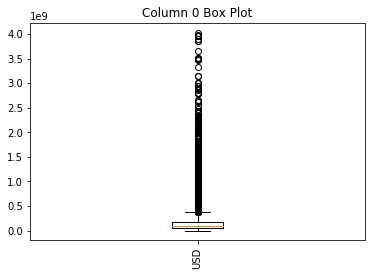

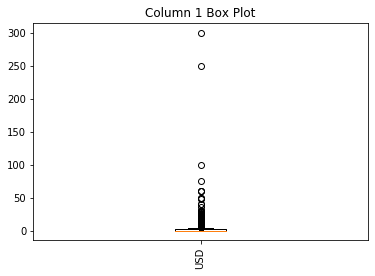

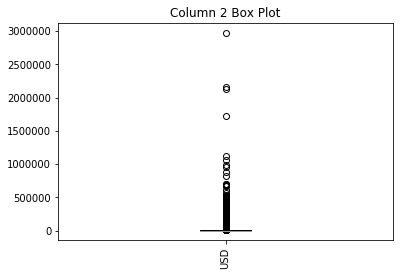

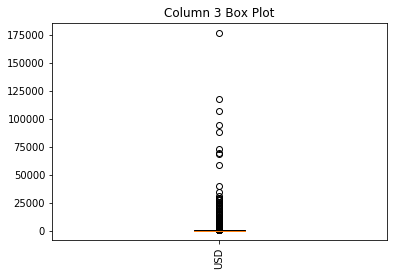

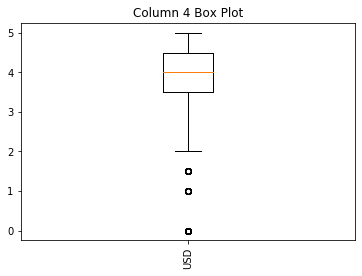

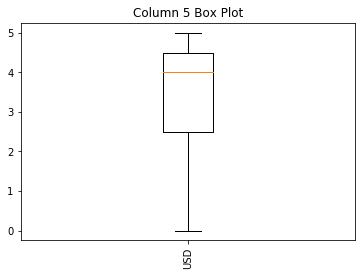

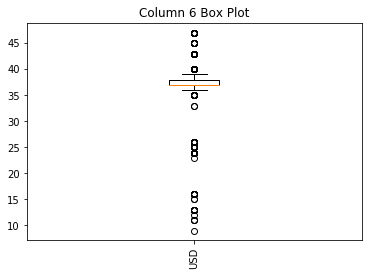

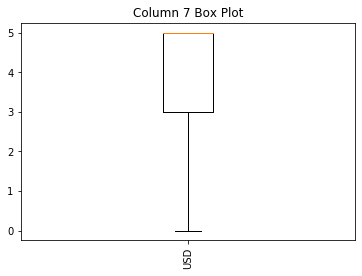

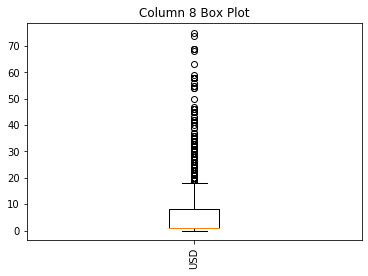

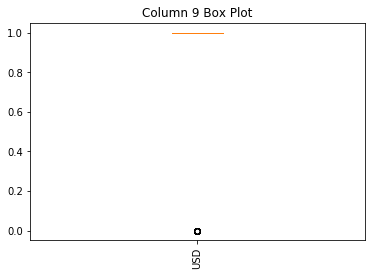

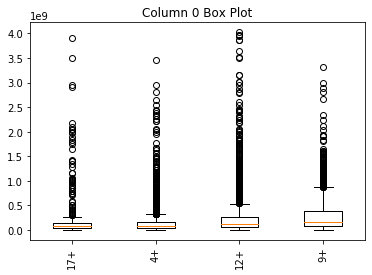

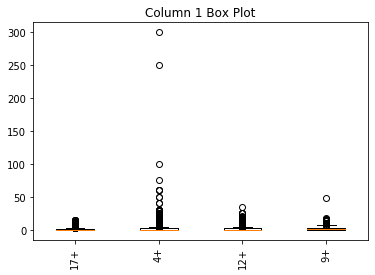

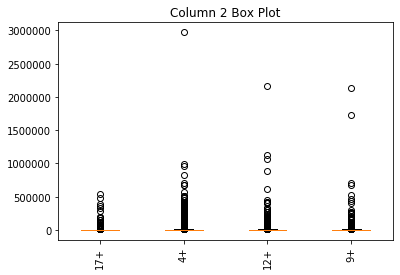

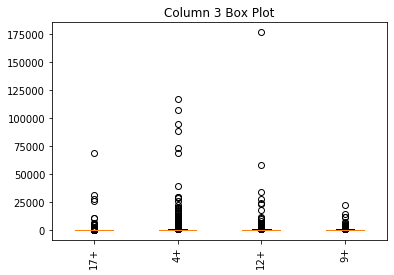

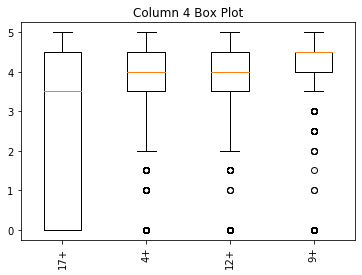

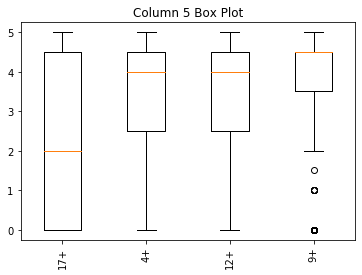

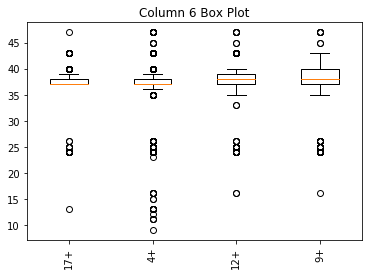

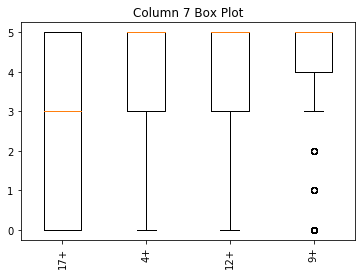

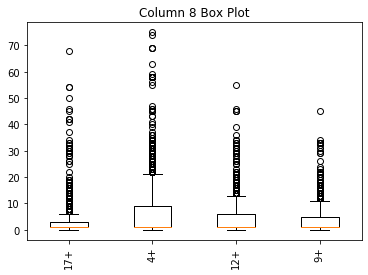

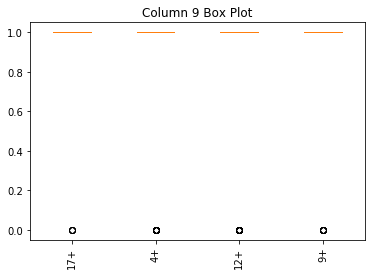

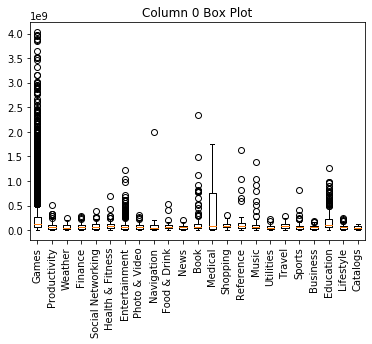

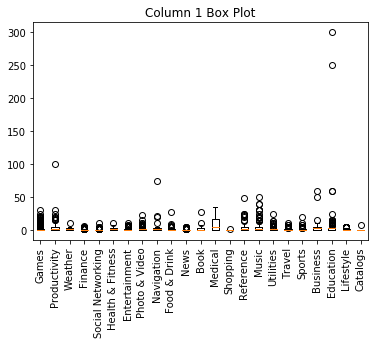

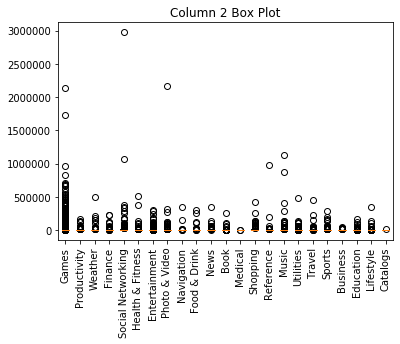

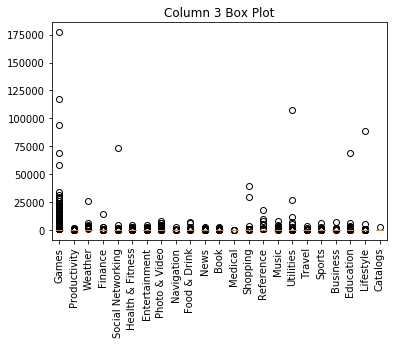

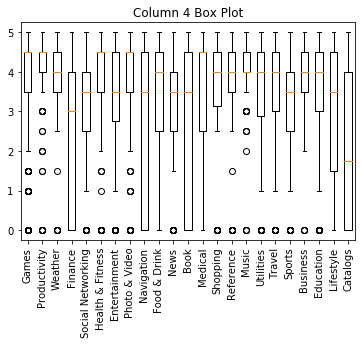

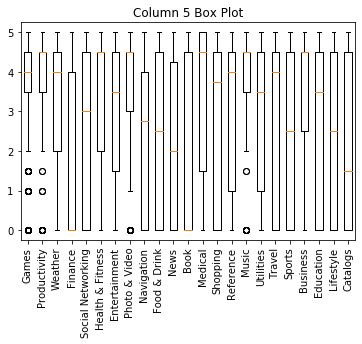

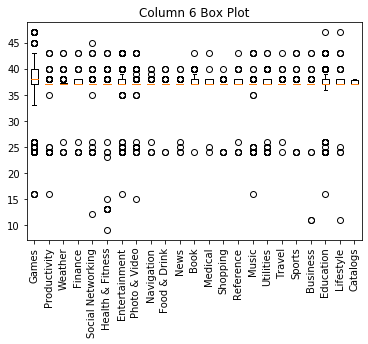

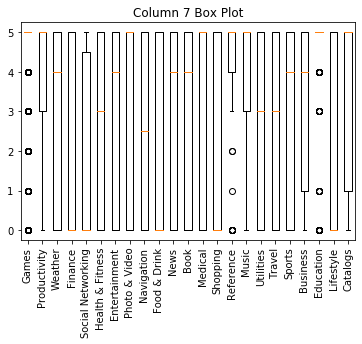

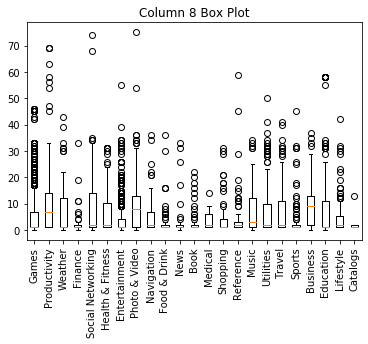

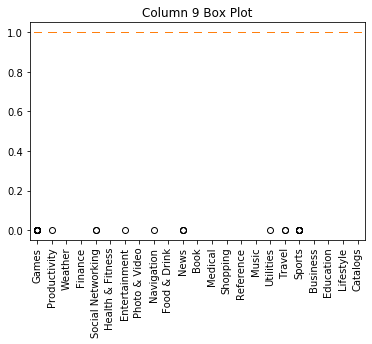

In [30]:

def get_column_stats(col_index, rdd_grouped_by_category):
    
    category_stats = []
    for category, rows in rdd_grouped_by_category.collect():
        col = [row[1][col_index][0] for row in rows]
        category_stats.append(col)
    plt.boxplot(category_stats)
    plt.title(f"Column {col_index} Box Plot")
    plt.xticks(range(1, len(category_stats)+1), grouped_rdd.keys().collect(), rotation=90)
    plt.show()

for i in [1,3,4]:
    grouped_rdd = rdd2.groupBy(lambda x: x[0][i])
    for j in range(10):
        get_column_stats(j, grouped_rdd)
        

### 9.Does length of app description contribute to the ratings?

In [31]:
rdd_desc=sc.textFile("appleStore_description.csv")
rdd_desc=rdd_desc.map(lambda row: csv.reader([row]).__next__())
header1=rdd_desc.first()
rdd_desc=rdd_desc.filter(lambda x:x!=header1 )

#print(header1,rdd_desc.take(4))


In [32]:
rdd_desc.count()

204029

#### Observe in file there are 7197 rows but here it is taking so many and even empty lists we are getting

In [33]:
rdd_desc=rdd_desc.filter(lambda x: x!=[])


#### convert RDDs to key-value pair RDDs to join based on Key

In [34]:
# convert RDDs to key-value pair RDDs
rdd_kv = rdd.map(lambda x: (x[1], x))
rdd_desc_kv = rdd_desc.map(lambda x: (x[0], x))
print(rdd_kv.take(2),rdd_desc_kv.take(2))

[('281656475', ['1', '281656475', 'PAC-MAN Premium', '100788224', 'USD', '3.99', '21292', '26', '4', '4.5', '6.3.5', '4+', 'Games', '38', '5', '10', '1']), ('281796108', ['2', '281796108', 'Evernote - stay organized', '158578688', 'USD', '0', '161065', '26', '4', '3.5', '8.2.2', '4+', 'Productivity', '37', '5', '23', '1'])] [('281656475', ['281656475', 'PAC-MAN Premium', '100788224', 'SAVE 20%, now only $3.99 for a limited time!']), ('One of the most popular video games in arcade history!', ['One of the most popular video games in arcade history!'])]


#### join based on key

In [35]:
# perform left join on id column
rdd_leftjoin = rdd_kv.leftOuterJoin(rdd_desc_kv)
rdd_leftjoin.take(1)

[('282614216',
  (['4',
    '282614216',
    'eBay: Best App to Buy, Sell, Save! Online Shopping',
    '128512000',
    'USD',
    '0',
    '262241',
    '649',
    '4',
    '4.5',
    '5.10.0',
    '12+',
    'Shopping',
    '37',
    '5',
    '9',
    '1'],
   ['282614216',
    'eBay: Best App to Buy, Sell, Save! Online Shopping',
    '128512000',
    "The eBay app is the best way to find anything you need, from dresses, handbags and fashion accessories to new & used cars. Browse our inventory of millions of products from sellers locally and globally to find exactly what you're looking for at a great price."]))]

#### transform each row of the RDD to a tuple with the key and a flattened list of values. Here's an example:

#### getting values in flattened list

In [36]:
rdd_left_join1 = rdd_leftjoin.map(lambda x:  x[1][0] + x[1][1])
#rdd_left_join1.take(1)


#### Adding lenofAppDescription

In [37]:
rdd_len_app=rdd_left_join1.map(lambda x: x+ [len(x[20])])
#rdd_len_app.take(1)

In [38]:
rdd_avg_len=rdd_len_app.map(lambda x: (float(x[8]), (int(x[21]), 1))).reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda x: x[0]/x[1])
rdd_avg_len.take(10)

[(4.0, 151.78843788437885),
 (4.5, 137.3086744273376),
 (0.0, 58.89881593110872),
 (5.0, 122.97967479674797),
 (1.5, 143.89285714285714),
 (1.0, 99.54545454545455),
 (2.5, 159.6734693877551),
 (2.0, 162.31132075471697),
 (3.5, 149.63390313390315),
 (3.0, 150.07310704960835)]

#### No effect on User rating vs appdescription length

## Using DataFrames and SQL

In [39]:
from pyspark.sql import SparkSession
# Create a SparkSession
spark = SparkSession.builder.appName("MobileAppStore").getOrCreate()

In [40]:
from pyspark.sql.functions import col,avg,first,last, max as maximum,min as minimum,length,mean, stddev,count,desc
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import IntegerType, LongType, DoubleType
import matplotlib.pyplot as plt

### 1. Load CSV into Spark as textfile

In [41]:
dfAppleStore = spark.read.csv("AppleStore.csv")
#dfAppleStore.show()-default shows top 20 rows
dfAppleStore.show(5)

+----+---------+--------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+------------+---------------+---------------+--------+-------+
| _c0|      _c1|                 _c2|       _c3|     _c4|  _c5|             _c6|             _c7|        _c8|            _c9|  _c10|       _c11|        _c12|           _c13|           _c14|    _c15|   _c16|
+----+---------+--------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+------------+---------------+---------------+--------+-------+
|null|       id|          track_name|size_bytes|currency|price|rating_count_tot|rating_count_ver|user_rating|user_rating_ver|   ver|cont_rating| prime_genre|sup_devices.num|ipadSc_urls.num|lang.num|vpp_lic|
|   1|281656475|     PAC-MAN Premium| 100788224|     USD| 3.99|           21292|              26|          4|            4.5| 6.3.5|         4+|       Games|             38

In [42]:
dfAppleStore1 = spark.read.csv("AppleStore.csv",header=True)
dfAppleStore1.show(5)

+---+---------+--------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+------------+---------------+---------------+--------+-------+
|_c0|       id|          track_name|size_bytes|currency|price|rating_count_tot|rating_count_ver|user_rating|user_rating_ver|   ver|cont_rating| prime_genre|sup_devices.num|ipadSc_urls.num|lang.num|vpp_lic|
+---+---------+--------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+------------+---------------+---------------+--------+-------+
|  1|281656475|     PAC-MAN Premium| 100788224|     USD| 3.99|           21292|              26|          4|            4.5| 6.3.5|         4+|       Games|             38|              5|      10|      1|
|  2|281796108|Evernote - stay o...| 158578688|     USD|    0|          161065|              26|          4|            3.5| 8.2.2|         4+|Productivity|             37|    

In [43]:
dfAppleStore1.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- size_bytes: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rating_count_tot: string (nullable = true)
 |-- rating_count_ver: string (nullable = true)
 |-- user_rating: string (nullable = true)
 |-- user_rating_ver: string (nullable = true)
 |-- ver: string (nullable = true)
 |-- cont_rating: string (nullable = true)
 |-- prime_genre: string (nullable = true)
 |-- sup_devices.num: string (nullable = true)
 |-- ipadSc_urls.num: string (nullable = true)
 |-- lang.num: string (nullable = true)
 |-- vpp_lic: string (nullable = true)



In [44]:
dfAppleStore = spark.read.csv("AppleStore.csv",header=True,inferSchema=True)
dfAppleStore.show(5)

+---+---------+--------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+------------+---------------+---------------+--------+-------+
|_c0|       id|          track_name|size_bytes|currency|price|rating_count_tot|rating_count_ver|user_rating|user_rating_ver|   ver|cont_rating| prime_genre|sup_devices.num|ipadSc_urls.num|lang.num|vpp_lic|
+---+---------+--------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+------------+---------------+---------------+--------+-------+
|  1|281656475|     PAC-MAN Premium| 100788224|     USD| 3.99|           21292|              26|        4.0|            4.5| 6.3.5|         4+|       Games|             38|              5|      10|      1|
|  2|281796108|Evernote - stay o...| 158578688|     USD|  0.0|          161065|              26|        4.0|            3.5| 8.2.2|         4+|Productivity|             37|    

In [45]:
dfAppleStore.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- track_name: string (nullable = true)
 |-- size_bytes: long (nullable = true)
 |-- currency: string (nullable = true)
 |-- price: double (nullable = true)
 |-- rating_count_tot: integer (nullable = true)
 |-- rating_count_ver: integer (nullable = true)
 |-- user_rating: double (nullable = true)
 |-- user_rating_ver: double (nullable = true)
 |-- ver: string (nullable = true)
 |-- cont_rating: string (nullable = true)
 |-- prime_genre: string (nullable = true)
 |-- sup_devices.num: integer (nullable = true)
 |-- ipadSc_urls.num: integer (nullable = true)
 |-- lang.num: integer (nullable = true)
 |-- vpp_lic: integer (nullable = true)



In [46]:
dfAppleStore.createOrReplaceTempView("AppleStore")

### 2. Parse the data as CSV

In [47]:
dfAppleStore.take(5)

[Row(_c0=1, id=281656475, track_name='PAC-MAN Premium', size_bytes=100788224, currency='USD', price=3.99, rating_count_tot=21292, rating_count_ver=26, user_rating=4.0, user_rating_ver=4.5, ver='6.3.5', cont_rating='4+', prime_genre='Games', sup_devices.num=38, ipadSc_urls.num=5, lang.num=10, vpp_lic=1),
 Row(_c0=2, id=281796108, track_name='Evernote - stay organized', size_bytes=158578688, currency='USD', price=0.0, rating_count_tot=161065, rating_count_ver=26, user_rating=4.0, user_rating_ver=3.5, ver='8.2.2', cont_rating='4+', prime_genre='Productivity', sup_devices.num=37, ipadSc_urls.num=5, lang.num=23, vpp_lic=1),
 Row(_c0=3, id=281940292, track_name='WeatherBug - Local Weather, Radar, Maps, Alerts', size_bytes=100524032, currency='USD', price=0.0, rating_count_tot=188583, rating_count_ver=2822, user_rating=3.5, user_rating_ver=4.5, ver='5.0.0', cont_rating='4+', prime_genre='Weather', sup_devices.num=37, ipadSc_urls.num=5, lang.num=3, vpp_lic=1),
 Row(_c0=4, id=282614216, track_n

In [48]:
dfAppleStore.collect()

[Row(_c0=1, id=281656475, track_name='PAC-MAN Premium', size_bytes=100788224, currency='USD', price=3.99, rating_count_tot=21292, rating_count_ver=26, user_rating=4.0, user_rating_ver=4.5, ver='6.3.5', cont_rating='4+', prime_genre='Games', sup_devices.num=38, ipadSc_urls.num=5, lang.num=10, vpp_lic=1),
 Row(_c0=2, id=281796108, track_name='Evernote - stay organized', size_bytes=158578688, currency='USD', price=0.0, rating_count_tot=161065, rating_count_ver=26, user_rating=4.0, user_rating_ver=3.5, ver='8.2.2', cont_rating='4+', prime_genre='Productivity', sup_devices.num=37, ipadSc_urls.num=5, lang.num=23, vpp_lic=1),
 Row(_c0=3, id=281940292, track_name='WeatherBug - Local Weather, Radar, Maps, Alerts', size_bytes=100524032, currency='USD', price=0.0, rating_count_tot=188583, rating_count_ver=2822, user_rating=3.5, user_rating_ver=4.5, ver='5.0.0', cont_rating='4+', prime_genre='Weather', sup_devices.num=37, ipadSc_urls.num=5, lang.num=3, vpp_lic=1),
 Row(_c0=4, id=282614216, track_n

In [49]:

spark.sql("select * from AppleStore").show(5)

+---+---------+--------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+------------+---------------+---------------+--------+-------+
|_c0|       id|          track_name|size_bytes|currency|price|rating_count_tot|rating_count_ver|user_rating|user_rating_ver|   ver|cont_rating| prime_genre|sup_devices.num|ipadSc_urls.num|lang.num|vpp_lic|
+---+---------+--------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+------------+---------------+---------------+--------+-------+
|  1|281656475|     PAC-MAN Premium| 100788224|     USD| 3.99|           21292|              26|        4.0|            4.5| 6.3.5|         4+|       Games|             38|              5|      10|      1|
|  2|281796108|Evernote - stay o...| 158578688|     USD|  0.0|          161065|              26|        4.0|            3.5| 8.2.2|         4+|Productivity|             37|    

### 3.Convert bytes to MB and GB in a new column

In [50]:
'''dfAppleStore=dfAppleStore.withColumn("size_mb",dfAppleStore.size_bytes/(1024*1024))
dfAppleStore=dfAppleStore.withColumn("size_gb",dfAppleStore.size_bytes/(1024*1024*1024))
dfAppleStore.printSchema()'''
dfAppleStore=dfAppleStore.withColumn("size_mb",dfAppleStore.size_bytes/(1024*1024)).withColumn("size_gb",dfAppleStore.size_bytes/(1024*1024*1024))
#dfAppleStore.printSchema()
dfAppleStore.select("size_bytes","size_mb","size_gb").show(10)

+----------+-----------------+--------------------+
|size_bytes|          size_mb|             size_gb|
+----------+-----------------+--------------------+
| 100788224|     96.119140625| 0.09386634826660156|
| 158578688|    151.232421875|  0.1476879119873047|
| 100524032|       95.8671875| 0.09362030029296875|
| 128512000|     122.55859375| 0.11968612670898438|
|  92774400|       88.4765625| 0.08640289306640625|
|  10485713|9.999955177307129|0.009765581227838993|
| 227795968|   217.2431640625| 0.21215152740478516|
| 130242560|    124.208984375| 0.12129783630371094|
|  49250304|         46.96875|   0.045867919921875|
|  70023168|     66.779296875| 0.06521415710449219|
+----------+-----------------+--------------------+
only showing top 10 rows



In [51]:
spark.sql("select id,size_bytes,size_bytes/1024*1024 as size_mb, size_bytes/1024*1024*1024 as size_gb from AppleStore").show(10)

+---------+----------+------------+----------------+
|       id|size_bytes|     size_mb|         size_gb|
+---------+----------+------------+----------------+
|281656475| 100788224|1.00788224E8|1.03207141376E11|
|281796108| 158578688|1.58578688E8|1.62384576512E11|
|281940292| 100524032|1.00524032E8|1.02936608768E11|
|282614216| 128512000|   1.28512E8|   1.31596288E11|
|282935706|  92774400|   9.27744E7|   9.50009856E10|
|283619399|  10485713| 1.0485713E7| 1.0737370112E10|
|283646709| 227795968|2.27795968E8|2.33263071232E11|
|284035177| 130242560| 1.3024256E8| 1.3336838144E11|
|284666222|  49250304| 4.9250304E7| 5.0432311296E10|
|284736660|  70023168| 7.0023168E7| 7.1703724032E10|
+---------+----------+------------+----------------+
only showing top 10 rows



###  4.List top 10 trending apps

In [52]:
dfAppleStore.sort("rating_count_tot",ascending=False).select(["id","track_name","rating_count_tot"]).show(10)

+---------+--------------------+----------------+
|       id|          track_name|rating_count_tot|
+---------+--------------------+----------------+
|284882215|            Facebook|         2974676|
|389801252|           Instagram|         2161558|
|529479190|      Clash of Clans|         2130805|
|420009108|          Temple Run|         1724546|
|284035177|Pandora - Music &...|         1126879|
|429047995|           Pinterest|         1061624|
|282935706|               Bible|          985920|
|553834731|    Candy Crush Saga|          961794|
|324684580|       Spotify Music|          878563|
|343200656|         Angry Birds|          824451|
+---------+--------------------+----------------+
only showing top 10 rows



In [53]:
spark.sql("select id, track_name,rating_count_tot from AppleStore order by rating_count_tot desc").show(10,False)

+---------+-----------------------+----------------+
|id       |track_name             |rating_count_tot|
+---------+-----------------------+----------------+
|284882215|Facebook               |2974676         |
|389801252|Instagram              |2161558         |
|529479190|Clash of Clans         |2130805         |
|420009108|Temple Run             |1724546         |
|284035177|Pandora - Music & Radio|1126879         |
|429047995|Pinterest              |1061624         |
|282935706|Bible                  |985920          |
|553834731|Candy Crush Saga       |961794          |
|324684580|Spotify Music          |878563          |
|343200656|Angry Birds            |824451          |
+---------+-----------------------+----------------+
only showing top 10 rows



### 5.The difference in the average number of screenshots displayed of highest and lowest rating apps.

* groupBy agg max,min,filter
* groupBy ,agg, orderBy,last,first
* groupBy ,agg, first,last

#### filter max,min ,groupBy, agg

In [54]:
#from pyspark.sql.functions import max as maximum,min as minimum
'''max_val = dfAppleStore.select("user_rating").rdd.reduce(lambda x, y: x if x[0] > y[0] else y)[0]
min_val= dfAppleStore.select("user_rating").rdd.reduce(lambda x, y: x if x[0] < y[0] else y)[0]
max_val = dfAppleStore.select(max("user_rating")).collect()[0][0]
min_val= dfAppleStore.select(min("user_rating")).collect()[0][0]'''
max_val = dfAppleStore.agg(maximum("user_rating")).collect()[0][0]
min_val = dfAppleStore.agg(minimum("user_rating")).collect()[0][0]

result_df=dfAppleStore.filter((col("user_rating") == max_val) | (col("user_rating")==min_val)).groupBy('user_rating').agg(avg('`ipadSc_urls.num`').alias("average"))
print(result_df.take(2)[1][1]-result_df.take(2)[0][1])

1.1310680248890757


#### filter max,min,window functions

In [55]:
#from pyspark.sql.window import Window
#from pyspark.sql.functions import avg, col

# filter the rows to include only the max and min user_rating values


# apply a window function to calculate the average of ipadSc_urls.num over the filtered rows
window_spec = Window.partitionBy('user_rating')
result_df = dfAppleStore.filter((col("user_rating") == max_val) | (col("user_rating") == min_val)).select('user_rating', avg('`ipadSc_urls.num`').over(window_spec).alias('average'))
print(result_df.distinct().take(2))
# calculate the difference between the two averages
'''max_avg = result_df.filter(col('user_rating') == max_val).select('average').collect()[0][0]
min_avg = result_df.filter(col('user_rating') == min_val).select('average').collect()[0][0]
diff = max_avg - min_avg
print(diff)'''
result_df.distinct().take(2)[1][1]-result_df.distinct().take(2)[0][1]

[Row(user_rating=0.0, average=2.582346609257266), Row(user_rating=5.0, average=3.7134146341463414)]


1.1310680248890757

#### using withColumn

In [56]:
spark.sql("SELECT  MAX(avg_ipadscurl) - MIN(avg_ipadscurl)  as diff FROM \
          (SELECT user_rating, AVG(`ipadSc_urls.num`) OVER (PARTITION BY user_rating) as avg_ipadscurl FROM AppleStore \
) temp \
WHERE user_rating IN (SELECT MAX(user_rating) FROM AppleStore UNION SELECT MIN(user_rating) FROM AppleStore) \
").limit(1).show()

+------------------+
|              diff|
+------------------+
|1.1310680248890757|
+------------------+



In [57]:
spark.sql("SELECT \
  MAX(avg_ipadSc_urls_num)  - MIN(avg_ipadSc_urls_num) AS diff \
FROM ( \
  SELECT \
    user_rating,  AVG(`ipadSc_urls.num`) OVER (PARTITION BY user_rating) AS avg_ipadSc_urls_num \
  FROM AppleStore \
) subquery \
WHERE user_rating = (SELECT MAX(user_rating) FROM AppleStore) OR user_rating = (SELECT MIN(user_rating) FROM AppleStore) \
").limit(1).show()

+------------------+
|              diff|
+------------------+
|1.1310680248890757|
+------------------+



In [58]:
spark.sql("SELECT \
  MAX(avg_ipadSc_urls_num) OVER()  - MIN(avg_ipadSc_urls_num) OVER () AS diff \
FROM ( \
  SELECT \
    user_rating,  AVG(`ipadSc_urls.num`) OVER (PARTITION BY user_rating) AS avg_ipadSc_urls_num \
  FROM AppleStore \
) subquery \
WHERE user_rating = (SELECT MAX(user_rating) FROM AppleStore) OR user_rating = (SELECT MIN(user_rating) FROM AppleStore) \
GROUP BY user_rating, avg_ipadSc_urls_num \
").show()

+------------------+
|              diff|
+------------------+
|1.1310680248890757|
|1.1310680248890757|
+------------------+



#### group by, avg,sort

### 6.What percentage of high rated apps support multiplelanguages.

In [59]:

dfAppleStore.filter((col("`lang.num`") > 1) & (col("user_rating") == 5)).count()/(dfAppleStore.filter("user_rating = 5").count())*100

47.5609756097561

In [60]:
spark.sql("select((select count(*) from AppleStore where `lang.num`>1 and user_rating=5)/(select count(*) from AppleStore where user_rating=5))*100").show()

+---------------------------------------------------------------------------------------------+
|((CAST(scalarsubquery() AS DOUBLE) / CAST(scalarsubquery() AS DOUBLE)) * CAST(100 AS DOUBLE))|
+---------------------------------------------------------------------------------------------+
|                                                                             47.5609756097561|
+---------------------------------------------------------------------------------------------+



### 7.How does app details contribute to user ratings?

#### Get numerical columns

In [61]:
# Get the column names and data types
dtypes = dfAppleStore.dtypes

# Filter out the columns with the desired data types
num_cols = [c[0] for c in dtypes if (c[1] == 'int' or c[1] == 'bigint' or c[1] == 'double')]
print(num_cols)

['_c0', 'id', 'size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic', 'size_mb', 'size_gb']


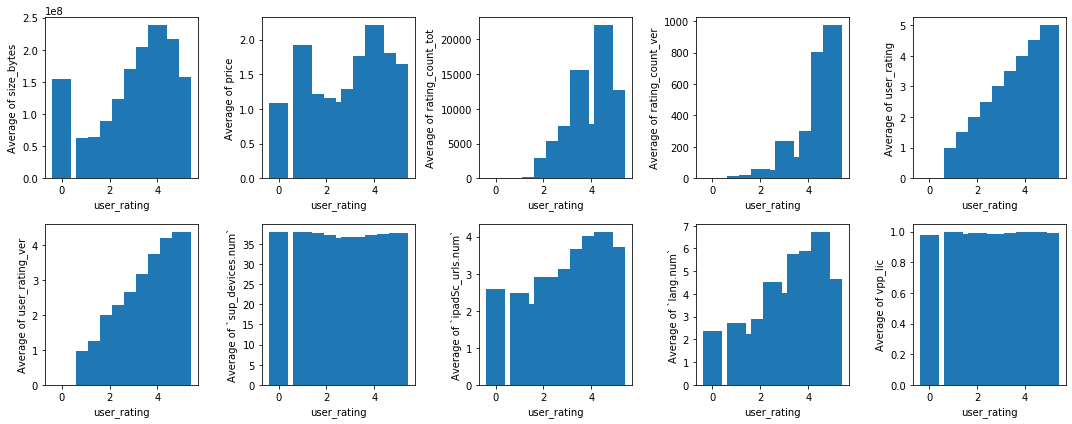

In [62]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6), tight_layout=True)
axs = axs.flatten()
window_spec = Window.partitionBy('user_rating')
for i, column in enumerate(['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', '`sup_devices.num`', '`ipadSc_urls.num`', '`lang.num`', 'vpp_lic']):
    result_df = dfAppleStore.select('user_rating', avg(column).over(window_spec).alias(f'average of {column}')).distinct()
    x = [r.user_rating for r in result_df.collect()]
    y = [r[f'average of {column}'] for r in result_df.collect()]
    axs[i].bar(x, y)
    axs[i].set_xlabel("user_rating")
    axs[i].set_ylabel(f"Average of {column}")
plt.show()


#### Correlation

#### Correlation between individual columns

#### Selecting numerical columns

#### Calculating correlation using pyspark dataframe

In [63]:
#from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.stat import Correlation


# Select the columns to compute correlation
selected_cols = ['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'vpp_lic']

# Create a vector assembler for the selected columns
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")
print(assembler)
# Transform the DataFrame to create a vector of features for each row
df_features = assembler.transform(dfAppleStore).select("features")
print(f"\ndf_features : {df_features.take(5)}")

# Compute the correlation matrix for the selected columns
corr_matrix = Correlation.corr(df_features, "features")
print(f"\nCorr_matrix: {corr_matrix.collect()}")

# Extract the correlation values as a list
corr_list = corr_matrix.collect()[0]["pearson({})".format("features")].toArray().tolist()

# Create a dictionary with pairs of column names and their corresponding correlation values
corr_dict = {column: corr_list[i] for i, column in enumerate(selected_cols)}

# Print the dictionary
print(f"\ncorr_dict:{corr_dict}")


VectorAssembler_88bbf61ae2c4

df_features : [Row(features=DenseVector([100788224.0, 3.99, 21292.0, 26.0, 4.0, 4.5, 1.0])), Row(features=DenseVector([158578688.0, 0.0, 161065.0, 26.0, 4.0, 3.5, 1.0])), Row(features=DenseVector([100524032.0, 0.0, 188583.0, 2822.0, 3.5, 4.5, 1.0])), Row(features=DenseVector([128512000.0, 0.0, 262241.0, 649.0, 4.0, 4.5, 1.0])), Row(features=DenseVector([92774400.0, 0.0, 985920.0, 5320.0, 4.5, 5.0, 1.0]))]

Corr_matrix: [Row(pearson(features)=DenseMatrix(7, 7, [1.0, 0.1824, 0.0045, 0.0063, 0.0663, 0.0861, -0.1504, 0.1824, ..., 0.0501, -0.1504, -0.0299, -0.001, 0.0065, 0.0698, 0.0501, 1.0], False))]

corr_dict:{'size_bytes': [1.0, 0.18239187109377464, 0.004486316612060427, 0.0063371687357631455, 0.06625571997806161, 0.08607466359584676, -0.1504177162843421], 'price': [0.18239187109377464, 1.0, -0.03904419411403899, -0.01801184178838808, 0.04660100362143263, 0.025173325443188968, -0.029942472238529347], 'rating_count_tot': [0.004486316612060427, -0.0390441941

In [64]:
from pyspark.sql.functions import corr

cols=['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'vpp_lic']


# Assuming your dataframe is named 'df'
correlations = dfAppleStore.select([corr(c1, c2).alias(f"corr({c1}, {c2})") for i, c1 in enumerate(cols) for c2 in cols[i+1:]])

print(correlations.collect())

[Row(corr(size_bytes, price)=0.18239187109377109, corr(size_bytes, rating_count_tot)=0.004486316612060564, corr(size_bytes, rating_count_ver)=0.0063371687357633025, corr(size_bytes, user_rating)=0.0662557199780597, corr(size_bytes, user_rating_ver)=0.08607466359584602, corr(size_bytes, vpp_lic)=-0.15041771628434716, corr(price, rating_count_tot)=-0.03904419411403824, corr(price, rating_count_ver)=-0.018011841788388105, corr(price, user_rating)=0.04660100362142496, corr(price, user_rating_ver)=0.025173325443183157, corr(price, vpp_lic)=-0.029942472238369464, corr(rating_count_tot, rating_count_ver)=0.1636446033513867, corr(rating_count_tot, user_rating)=0.0833099660459741, corr(rating_count_tot, user_rating_ver)=0.08874354725991247, corr(rating_count_tot, vpp_lic)=-0.000982322947934822, corr(rating_count_ver, user_rating)=0.06875413255961159, corr(rating_count_ver, user_rating_ver)=0.0778400956372926, corr(rating_count_ver, vpp_lic)=0.006460467135922623, corr(user_rating, user_rating_ve

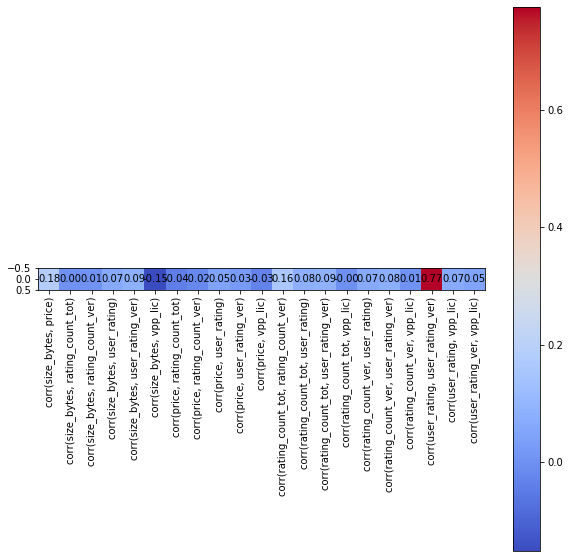

In [65]:
import numpy as np
corr_array = np.array([list(row.asDict().values()) for row in correlations.collect()])

# create heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(corr_array, cmap='coolwarm', interpolation='nearest')

# set labels
len_cols = len(correlations.columns)
ax.set_xticks(np.arange(len_cols))
#ax.set_yticks(np.arange(num_cols))
ax.set_xticklabels(list(correlations.columns), rotation=90)
#ax.set_yticklabels(list(correlations.columns))



# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

for i in range(1):
    for j in range(len_cols):
        text = ax.text(j, i, f'{corr_array[i, j]:.2f}', ha='center', va='center', color='black')


# show plot
plt.show()

In [66]:
import pyspark.sql.functions as F
import numpy as np
corr_rows = correlations.collect()

# Extract values from rows as a list of lists
corr_values = [[float(row[i]) for i in range(len(row))] for row in corr_rows]

# Convert list of lists to numpy array
correlation_matrix = np.array(corr_values)

# visualize correlation matrix
display(correlation_matrix)

array([[ 0.18239187,  0.00448632,  0.00633717,  0.06625572,  0.08607466,
        -0.15041772, -0.03904419, -0.01801184,  0.046601  ,  0.02517333,
        -0.02994247,  0.1636446 ,  0.08330997,  0.08874355, -0.00098232,
         0.06875413,  0.0778401 ,  0.00646047,  0.77413985,  0.06981648,
         0.05009424]])

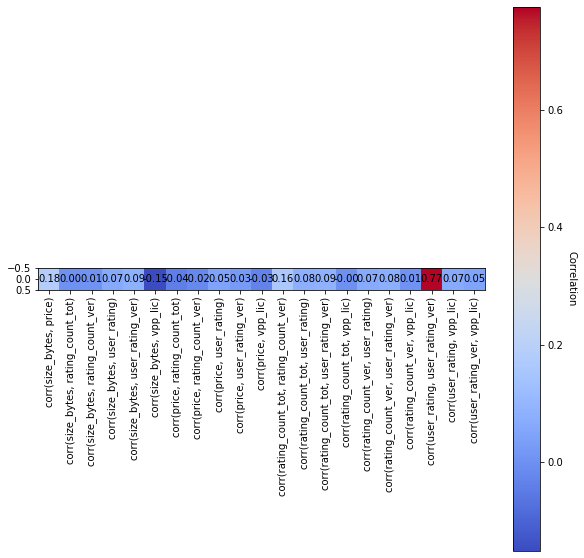

In [67]:


# plot the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(corr_array, cmap='coolwarm', interpolation='nearest')

# set labels

len_cols = len(correlation_matrix[0])
ax.set_xticks(np.arange(len_cols))
#ax.set_yticks(np.arange(num_cols))
ax.set_xticklabels(list(correlations.columns), rotation=90)

# add annotations
for i in range(1):
    for j in range(len(correlation_matrix[0])):
        text = ax.text(j, i, "{:.2f}".format(correlation_matrix[i, j]),
                       ha="center", va="center", color="black")

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom")

plt.show()


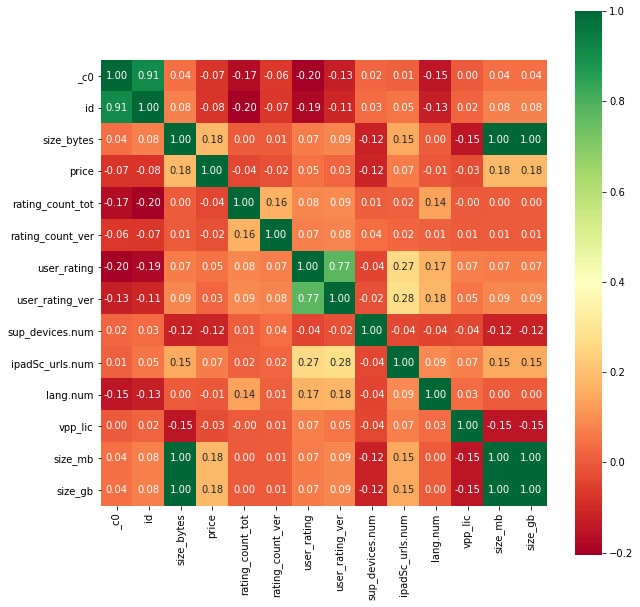

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(dfAppleStore.toPandas().corr(), cmap='RdYlGn', square=True,annot=True,fmt='.2f')


* More ipadSC_urls.num,lang.num more user rating


### 8.Compare the statistics of different app groups/genres.

In [69]:
num_cols[2:8]+num_cols[11:]

['size_bytes',
 'price',
 'rating_count_tot',
 'rating_count_ver',
 'user_rating',
 'user_rating_ver',
 'vpp_lic',
 'size_mb',
 'size_gb']

In [70]:

# Calculate statistics for the columns with each data type
stats = dfAppleStore.select(num_cols[2:8]+num_cols[11:]).describe().show()



+-------+-------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+------------------+------------------+
|summary|         size_bytes|             price|  rating_count_tot|  rating_count_ver|      user_rating|  user_rating_ver|            vpp_lic|           size_mb|           size_gb|
+-------+-------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+------------------+------------------+
|  count|               7197|              7197|              7197|              7197|             7197|             7197|               7197|              7197|              7197|
|   mean| 1.99134453825066E8|1.7262178685562626|12892.907183548701| 460.3739057940809|3.526955675976101|3.253577879672086| 0.9930526608309017|189.90941412455177|0.1854584122310076|
| stddev|3.592069135387029E8| 5.833005786951921| 75739.40867472602|3920.4551833619757|1.5179475

In [71]:
dfAppleStore.describe().toPandas()

,summary,_c0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,size_mb,size_gb
0,count,7197,7197,7197,7197,7197,7197,7197,7197,7197,7197,7197,7197,7197,7197,7197,7197,7197,7197,7197
1,mean,4759.069612338474,8.631309974515771E8,1824.0,1.99134453825066E8,None,1.7262178685562626,12892.907183548701,460.3739057940809,3.526955675976101,3.253577879672086,7.968864512292031,None,None,37.36181742392664,3.7071001806308184,5.43490343198555,0.9930526608309017,189.90941412455177,0.1854584122310076
2,stddev,3093.6252131502906,2.7123675589291865E8,316.7838379715733,3.592069135387029E8,None,5.833005786951921,75739.40867472602,3920.4551833619757,1.517947593629884,1.809362823117772,107.74333834045682,None,None,3.7377152388584527,1.9860046449596336,7.919592722881359,0.08306643356297923,342.56640771742144,0.3345375075365444
3,min,1,281656475,! OH Fantastic Free Kick + Kick Wall Challenge,589824,USD,0.0,0,0,0.0,0.0,0.0.15,12+,Book,9,0,0,0,0.5625,5.4931640625E-4
4,max,11097,1188375727,ｗｗｗ,4025969664,USD,299.99,2974676,177050,5.0,5.0,v3.6.9,9+,Weather,47,5,75,1,3839.4638671875,3.749476432800293


In [72]:
#from pyspark.sql.types import IntegerType, LongType, DoubleType

# Get the schema of the DataFrame
schema = dfAppleStore.schema

# Find columns with int, bigint and double datatype
'''int_cols = [i for i, field in enumerate(schema) if isinstance(field.dataType, IntegerType)]
long_cols = [i for i, field in enumerate(schema) if isinstance(field.dataType, LongType)]
double_cols = [i for i, field in enumerate(schema) if isinstance(field.dataType, DoubleType)]'''
num_cols = [i for i, field in enumerate(schema) if (isinstance(field.dataType, IntegerType) or isinstance(field.dataType, LongType) or isinstance(field.dataType, DoubleType))]

# Create a new RDD with selected columns and compute stats
#selected_cols_rdd1 = dfAppleStore.rdd.map(lambda row: [row[i] for i in int_cols+long_cols+double_cols])
#col_stats1 = [selected_cols_rdd1.map(lambda x: x[i]).stats() for i in range(len(selected_cols_rdd1.first()))]
selected_cols_rdd = dfAppleStore.rdd.map(lambda row: [row[i] for i in num_cols[2:]])
col_stats = [selected_cols_rdd.map(lambda x: x[i]).stats() for i in range(len(selected_cols_rdd.first()))]
col_stats

[(count: 7197, mean: 199134453.82506594, stdev: 359181957.3491748, max: 4025969664.0, min: 589824.0),
 (count: 7197, mean: 1.7262178685563452, stdev: 5.832600534178518, max: 299.99, min: 0.0),
 (count: 7197, mean: 12892.907183548667, stdev: 75734.14661832791, max: 2974676.0, min: 0.0),
 (count: 7197, mean: 460.37390579408157, stdev: 3920.182806581617, max: 177050.0, min: 0.0),
 (count: 7197, mean: 3.526955675976098, stdev: 1.5178421329986644, max: 5.0, min: 0.0),
 (count: 7197, mean: 3.2535778796720827, stdev: 1.809237116178855, max: 5.0, min: 0.0),
 (count: 7197, mean: 37.36181742392672, stdev: 3.737455558082869, max: 47.0, min: 9.0),
 (count: 7197, mean: 3.707100180630823, stdev: 1.9858666656879234, max: 5.0, min: 0.0),
 (count: 7197, mean: 5.43490343198554, stdev: 7.919042502800598, max: 75.0, min: 0.0),
 (count: 7197, mean: 0.9930526608309049, stdev: 0.08306066245562778, max: 1.0, min: 0.0),
 (count: 7197, mean: 189.90941412455172, stdev: 342.5426076404331, max: 3839.4638671875, mi

#### 8.Compare the statistics of different app groups/genres.

In [73]:
dfAppleStore.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- track_name: string (nullable = true)
 |-- size_bytes: long (nullable = true)
 |-- currency: string (nullable = true)
 |-- price: double (nullable = true)
 |-- rating_count_tot: integer (nullable = true)
 |-- rating_count_ver: integer (nullable = true)
 |-- user_rating: double (nullable = true)
 |-- user_rating_ver: double (nullable = true)
 |-- ver: string (nullable = true)
 |-- cont_rating: string (nullable = true)
 |-- prime_genre: string (nullable = true)
 |-- sup_devices.num: integer (nullable = true)
 |-- ipadSc_urls.num: integer (nullable = true)
 |-- lang.num: integer (nullable = true)
 |-- vpp_lic: integer (nullable = true)
 |-- size_mb: double (nullable = true)
 |-- size_gb: double (nullable = true)



In [74]:
#from pyspark.sql.functions import mean, stddev,count

# calculate mean and standard deviation of numerical columns
dfAppleStore.select(mean("size_bytes"), mean("price"), mean("rating_count_tot"), mean("user_rating"), mean("user_rating_ver") ).show()#''',mean("sup_devices.num"), mean("ipadSc_urls.num"), mean("lang.num")'''
dfAppleStore.select(stddev("size_bytes"), stddev("price"), stddev("rating_count_tot"), stddev("user_rating"), stddev("user_rating_ver")).show()#''', stddev("sup_devices.num"), stddev("ipadSc_urls.num"), stddev("lang.num")'''

# calculate mode of categorical columns
#from pyspark.sql.functions import desc


dfAppleStore.groupBy("currency").agg(count("*").alias("count")).orderBy(desc("count")).limit(5).show()
dfAppleStore.groupBy("cont_rating").agg(count("*").alias("count")).orderBy(desc("count")).limit(5).show()
dfAppleStore.groupBy("prime_genre").agg(count("*").alias("count")).orderBy(desc("count")).limit(5).show()
dfAppleStore.groupBy("track_name").agg(count("*").alias("count")).orderBy(desc("count")).limit(5).show()

+------------------+------------------+---------------------+-----------------+--------------------+
|   avg(size_bytes)|        avg(price)|avg(rating_count_tot)| avg(user_rating)|avg(user_rating_ver)|
+------------------+------------------+---------------------+-----------------+--------------------+
|1.99134453825066E8|1.7262178685562626|   12892.907183548701|3.526955675976101|   3.253577879672086|
+------------------+------------------+---------------------+-----------------+--------------------+

+-----------------------+------------------+-----------------------------+------------------------+----------------------------+
|stddev_samp(size_bytes)|stddev_samp(price)|stddev_samp(rating_count_tot)|stddev_samp(user_rating)|stddev_samp(user_rating_ver)|
+-----------------------+------------------+-----------------------------+------------------------+----------------------------+
|    3.592069135387029E8| 5.833005786951921|            75739.40867472602|       1.517947593629884|        

### 9.Does length of app description contribute to the ratings?

In [75]:
dfAppleStoreDesc=spark.read.csv("appleStore_description.csv",header=True,inferSchema=True)
dfAppleStoreDesc.show(10)

+--------------------+--------------------+--------------------+--------------------+
|                  id|          track_name|          size_bytes|            app_desc|
+--------------------+--------------------+--------------------+--------------------+
|           281656475|     PAC-MAN Premium|           100788224|SAVE 20%, now onl...|
|One of the most p...|                null|                null|                null|
|2015 World Video ...|                null|                null|                null|
|Who can forget th...|                null|                null|                null|
|Guide PAC-MAN thr...|    a MFi controller| or kick it old s...|                null|
|Eat all of the do...| the leader of th...| and his fellow g...|                Inky|
|9 NEW MAZES Inclu...|                null|                null|                null|
|The game includes...|                null|                null|                null|
|   HINTS and TIPS!!!|                null|           

In [76]:
dfAppleStoreDesc.createOrReplaceTempView("appleStore_description")

In [77]:
dfAppleStore.show(5)

+---+---------+--------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+------------+---------------+---------------+--------+-------+-------------+-------------------+
|_c0|       id|          track_name|size_bytes|currency|price|rating_count_tot|rating_count_ver|user_rating|user_rating_ver|   ver|cont_rating| prime_genre|sup_devices.num|ipadSc_urls.num|lang.num|vpp_lic|      size_mb|            size_gb|
+---+---------+--------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+------------+---------------+---------------+--------+-------+-------------+-------------------+
|  1|281656475|     PAC-MAN Premium| 100788224|     USD| 3.99|           21292|              26|        4.0|            4.5| 6.3.5|         4+|       Games|             38|              5|      10|      1| 96.119140625|0.09386634826660156|
|  2|281796108|Evernote - stay o...| 158

In [78]:
#from pyspark.sql.functions import length
# join the two dataframes on the "id" column
df = dfAppleStore.join(dfAppleStoreDesc, on="id", how="left")

In [79]:
dfAppleStore.count(),dfAppleStoreDesc.count(),df.count()

(7197, 145897, 7197)

In [80]:

# create a new column with the length of app description
df = df.withColumn("app_desc_len", length("app_desc"))
df.show(5)

+---------+----+------------------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+-----------+---------------+---------------+--------+-------+-------------+-------------------+------------------------------+----------+-----------------------------------+------------+
|       id| _c0|                    track_name|size_bytes|currency|price|rating_count_tot|rating_count_ver|user_rating|user_rating_ver|   ver|cont_rating|prime_genre|sup_devices.num|ipadSc_urls.num|lang.num|vpp_lic|      size_mb|            size_gb|                    track_name|size_bytes|                           app_desc|app_desc_len|
+---------+----+------------------------------+----------+--------+-----+----------------+----------------+-----------+---------------+------+-----------+-----------+---------------+---------------+--------+-------+-------------+-------------------+------------------------------+----------+---------------------------

In [81]:
df.select('id','app_desc').show(5)

+---------+--------------------+
|       id|            app_desc|
+---------+--------------------+
|281656475|SAVE 20%, now onl...|
|281796108|Let Evernote chan...|
|281940292|Download the most...|
|282614216|The eBay app is t...|
|282935706|On more than 250 ...|
+---------+--------------------+
only showing top 5 rows



In [82]:
#df.filter(col("id").isNull()).show()
df.filter(df.id.isNull()).count(),df.filter(col("app_desc").isNull()).count()


(0, 0)

In [83]:
df.withColumn("len_of_appdesc",length('app_desc')).select('len_of_appdesc','user_rating').orderBy('len_of_appdesc', ascending=False).limit(30).show()

+--------------+-----------+
|len_of_appdesc|user_rating|
+--------------+-----------+
|          1792|        4.0|
|          1386|        4.0|
|           988|        4.0|
|           949|        4.0|
|           920|        4.5|
|           918|        5.0|
|           893|        4.0|
|           838|        5.0|
|           799|        4.0|
|           798|        4.0|
|           796|        4.0|
|           795|        5.0|
|           790|        5.0|
|           765|        4.0|
|           745|        3.0|
|           742|        4.5|
|           742|        2.5|
|           734|        4.5|
|           725|        5.0|
|           711|        4.0|
+--------------+-----------+
only showing top 20 rows



In [84]:
df.withColumn("len_of_appdesc",length('app_desc')).select('user_rating', avg('len_of_appdesc').over(window_spec).alias('average length of app_desc')).distinct().orderBy('user_rating').show(30)

+-----------+--------------------------+
|user_rating|average length of app_desc|
+-----------+--------------------------+
|        0.0|        56.783638320775026|
|        1.0|         93.47727272727273|
|        1.5|        143.94642857142858|
|        2.0|         161.9433962264151|
|        2.5|        158.53571428571428|
|        3.0|        145.92167101827675|
|        3.5|         146.5185185185185|
|        4.0|        149.74046740467404|
|        4.5|           135.52384528727|
|        5.0|         120.7459349593496|
+-----------+--------------------------+



In [85]:
spark.sql("select distinct user_rating, avg(length(app_desc)) over(PARTITION BY user_rating) from AppleStore A join appleStore_description B on A.id=B.id").show()

+-----------+------------------------------------------------------------------------------------------------------------------------------+
|user_rating|avg(CAST(length(app_desc) AS BIGINT)) OVER (PARTITION BY user_rating ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)|
+-----------+------------------------------------------------------------------------------------------------------------------------------+
|        0.0|                                                                                                            56.783638320775026|
|        3.5|                                                                                                             146.5185185185185|
|        4.5|                                                                                                               135.52384528727|
|        2.5|                                                                                                            158.53571428571428|
|        1.0|

In [86]:


# calculate the correlation between app description length and user rating
corr = df.stat.corr("app_desc_len", "user_rating")

print("Correlation between app description length and user rating: ", corr)


Correlation between app description length and user rating:  0.1833952250197063


* As length decreases no change in user_rating
* Avg length of appdesc doesn't effect user rating

* Very less Correlation